In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import cv2
import torch
import pywt
from torch import nn
from torchsummary import summary
from torch.optim import SGD
import torch.optim as optim
from tensorflow.keras.utils import array_to_img, img_to_array
from torch.autograd import Variable

In [3]:
# Define the height of the image in pixels
im_height = 134

# Define the width of the image in pixels
im_width = 300

# Define the depth of the image in pixels
im_depth = 300

In [4]:
def remove_background1(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (torch.mean(tensor_flattened) - torch.std(tensor_flattened))
    threshold1 = (torch.mean(tensor_flattened) + torch.std(tensor_flattened*2))
    
    # Apply thresholding to remove background
    return (((threshold) < img) * ((threshold1) >= img) * (img + threshold))+((threshold1 < img)*threshold1)
    #return ((threshold) < img) * (img)

In [5]:
# Set the data type of tensors to be FloatTensor stored on the GPU
# This means tensors will contain floating-point numbers and reside in GPU memory
dtype = torch.cuda.FloatTensor

In [6]:
# Define the batch size for processing data in mini-batches
BATCH_SIZE = 1

In [7]:
# Load pre-trained models from saved checkpoints
modelx = torch.load('/kaggle/input/unet_deploy_github/pytorch/default/1/checkpoint_x.pt')
modely = torch.load('/kaggle/input/unet_deploy_github/pytorch/default/1/checkpoint_y.pt')
modelz = torch.load('/kaggle/input/unet_deploy_github/pytorch/default/1/checkpoint_z.pt')
# Create an instance of the UNet3D model
model = torch.load('/kaggle/input/unet_deploy_github/pytorch/default/1/checkpoint_unet.pt')

# Move the model to CUDA (GPU)
model.cuda()

<ipython-input-7-42f74b8f65de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelx = torch.load('/kaggle/input/unet_deploy_github/pytorch/default/1/checkpoint_x.pt')
/us

RecursiveScriptModule(
  original_name=UNET3D
  (in1): RecursiveScriptModule(original_name=BatchNorm3d)
  (a_block1): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
      (3): RecursiveScriptModule(original_name=Conv3d)
    )
    (upconv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
      (3): RecursiveScriptModule(original_name=Conv3d)
    )
  )
  (d_block1): RecursiveScriptModule(
    original_name=Residualdense
    (block1): RecursiveScriptModule(
      original_name=Conv3DBlock
      (conv1): RecursiveScriptModule(
        original_name=Sequential
        (0):

In [8]:
# Move the pre-trained models to the GPU for computation
modelx.cuda()
modely.cuda()
modelz.cuda()
model.cuda()

RecursiveScriptModule(
  original_name=UNET3D
  (in1): RecursiveScriptModule(original_name=BatchNorm3d)
  (a_block1): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
      (3): RecursiveScriptModule(original_name=Conv3d)
    )
    (upconv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
      (3): RecursiveScriptModule(original_name=Conv3d)
    )
  )
  (d_block1): RecursiveScriptModule(
    original_name=Residualdense
    (block1): RecursiveScriptModule(
      original_name=Conv3DBlock
      (conv1): RecursiveScriptModule(
        original_name=Sequential
        (0):

In [9]:
# Initialize variables x, y, and z to zero
x = 0
y = 0
z = 0

In [10]:
def clean_array(x):
    # Initialize variables to store the indices of the predicted boundary
    front = -1
    back = -1
    
    # Find the front boundary of the predicted array
    j = 0
    while x[0][j] == 0:
        front = j + 1
        j = j + 1
        
    # Find the back boundary of the predicted array
    j = x.cpu().numpy().shape[1] - 1
    while x[0][j] == 0:
        back = j - 1
        j = j - 1
        
    # Return the indices of the predicted boundary
    return front, back

In [11]:
def resize_mid(back, front, val, val2):
    # Calculate the midpoint between back and front indices
    mid1 = int((val - back + front - 1) / 2)
    mid = mid1
    # Adjust midpoint if the total length is odd
    if (back - front + 1) % 2 == 1:
        mid = mid1 + 1
    
    # Adjust front and back indices based on the midpoint
    front = front - mid1
    back = back + mid
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2 - 1):
        front = front - (back - (val2 - 1))
        back = val2 - 1
        
    # Check if front index is less than zero, adjust front and back indices accordingly
    if front < 0:
        back = back - front
        front = 0
    
    # Return adjusted front and back indices
    return front, back

In [12]:
# Define the data type for tensors to be stored on the GPU
dtype = torch.cuda.FloatTensor

In [13]:
# Define the dimensions of an image volume
im_height1 = 128  # Height of the image volume
im_width1 = 200   # Width of the image volume
im_depth1 = 128   # Depth of the image volume

In [14]:
loss_checkpoint = 1000
count = 0
loss = 0
val_loss = 0

# Evaluate the model
def run(path):
    # Load the image file using NumPy
    img = np.load(path)
    org=img
    Z_org=img.shape[2]
    org=np.resize(org.transpose(),(1,Z_org,512,512))
    org=(org-np.min(org))/(np.max(org)-np.min(org))
    # Check if the image depth is greater than or equal to 183
    if img.shape[2] >= 183:
        # Crop the image based on specified dimensions
        image = img[150:450, 150:450, 49:183]
        z1=49
        z2=183
    else:
        # Crop the image based on different specified dimensions
        image = img[150:450, 150:450, 39:173]
        z1=39
        z2=173

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    X = torch.Tensor(img)
    
    img = X
    # Convert inputs to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0).unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    frontx, backx = clean_array(yhatx)
    if backx - frontx + 1 < im_width1:
        frontx, backx = resize_mid(frontx, backx, im_width1, im_width)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0).unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    fronty, backy = clean_array(yhaty)
    if backy - fronty + 1 < im_depth1:
        fronty, backy = resize_mid(fronty, backy, im_depth1, im_depth)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0).unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    frontz, backz = clean_array(yhatz)
    if backz - frontz + 1 < im_height1:
        frontz, backz = resize_mid(frontz, backz, im_height1, im_height)
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img = img[frontz:backz + 1, frontx:backx + 1, fronty:backy + 1]
    img=np.resize(img, (1, im_height1, im_width1, im_depth1))
    #print(img.shape)
    
    # Perform wavelet reconstruction on the image tensor
    img = pywt.waverecn(coeffs=img, wavelet='cmor', mode='symmetric', axes=(-3, -2, -1))
    
    # Remove background from the image tensor
    img = remove_background1(img)

    # Resize and store input images
    X=np.resize(img, (1, im_height1, im_width1, im_depth1))
    X = torch.Tensor(X)
    inputs=Variable(X).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    yhat=yhat.cpu().numpy()
    label=np.zeros((1,Z_org,512,512))
    label[:,z1+frontz:z1+frontz+128,150+frontx:150+frontx+200, 150+fronty:150+fronty+128]=yhat
    #label=list(label)
    return label+org

In [15]:
x=run('/kaggle/input/pancreasct-dataset/images/0001.npy')
print(np.shape(x))

(1, 240, 512, 512)


In [16]:
def print_image(x, slice_no):
    plt.figure()

    # Create subplots with specified number of rows and columns
    f, axarr = plt.subplots(len(slice_no))

    # Iterate over slice numbers
    for i in range(len(slice_no)):
        # Display original image in the first column
        axarr[i].imshow(np.resize(x[slice_no[i]], (x.shape[1], x.shape[2], 1)))

<Figure size 640x480 with 0 Axes>

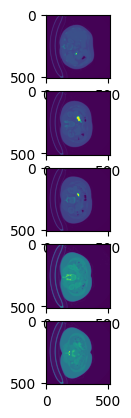

In [17]:
print_image(((x))[0],[100,150,160,180,200])